In [ ]:
import os

import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report,confusion_matrix
from tensorflow.keras.models import load_model
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.regularizers import l2

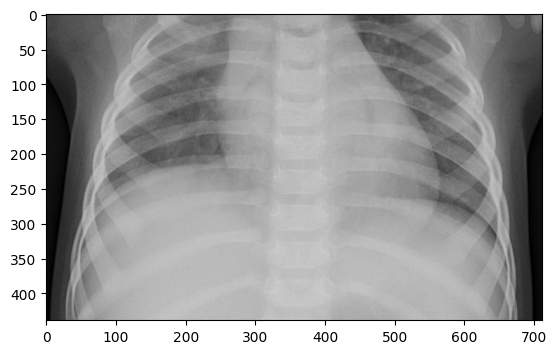

In [ ]:
img=mpimg.imread('data/PNEUMONIA/person1_bacteria_1.jpeg')
plt.imshow(img)

In [ ]:
normal_path = 'data/NORMAL'
pneumonia_path = 'data/PNEUMONIA'
covid_path = 'data/COVID'
cardiomegaly_path = 'data/CARDIOMEGALY'

In [4]:
classes = {
    0: "Normal", 
    1: "Pneumonia", 
    2: "Covid", 
    3: "Cardiomegaly"
}

In [5]:
def count_files(directory_path):

    if os.path.exists(directory_path) and os.path.isdir(directory_path):
        return len([f for f in os.listdir(directory_path) if os.path.isfile(os.path.join(directory_path, f))])
    
    return 0


n_normal = count_files(normal_path)
n_pneumonia = count_files(pneumonia_path)
n_covid = count_files(covid_path)
n_cardiomegaly = count_files(cardiomegaly_path)

In [6]:
image_counts = [n_normal, n_pneumonia, n_covid, n_cardiomegaly]
class_names = [classes[i] for i in classes.keys()]
colors = ["darkseagreen", 'grey', 'grey', 'grey']

In [7]:
def plot_image_distribution(image_counts, class_names, colors):

    plt.figure(figsize=(12, 6))
    bars = plt.barh(class_names, image_counts, color=colors)

    for bar, count in zip(bars, image_counts):
        plt.text(bar.get_width() - (bar.get_width() * 0.05), bar.get_y() + bar.get_height() / 2,
                f'{count} Images', va='center', ha='right', color='white', fontsize=10)

    plt.xlabel('Number of Images')
    plt.title('Number of Images per Class')
    plt.show()

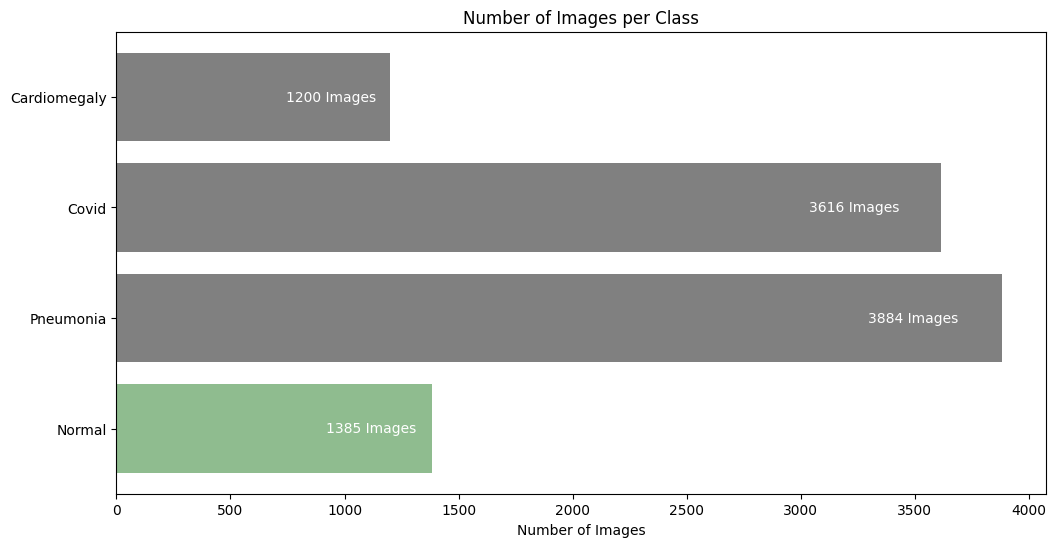

In [8]:
plot_image_distribution(image_counts, class_names, colors)

In [9]:
# ImageDataGenerator for augmentation
augmentation_gen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [10]:
def augment_image(image):

    for x_aug in augmentation_gen.flow(image, batch_size=1):
        
        return x_aug[0]


def process_images(path, augment=False):

    images = []

    for img_file in os.listdir(path):

        image_path = os.path.join(path, img_file)
        image = cv2.imread(image_path)

        if image is not None:

            image = cv2.resize(image, (128, 128))  # resize to 128x128
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # convert to RGB
            image = image / 255.0 # nomalize

            images.append(image)
            
            if augment:
                
                # reshape to have batch dimension for augmentation
                image = image.reshape((1,) + image.shape)
                
                num_aug_images = 2  # number of augmented images to generate per original image

                for _ in range(num_aug_images):

                    augmented_image = augment_image(image)
                    images.append(augmented_image)

        else:
            print(f"Warning: Unable to load image {img_file}")

    return images

In [ ]:
data = []
labels = []

In [ ]:
normal_images = process_images(normal_path, augment=True)
data.extend(normal_images)
n_normal_processed = len(normal_images)
labels.extend([0] * n_normal_processed)

pneumonia_images = process_images(pneumonia_path, augment=False)
data.extend(pneumonia_images)
n_pneumonia_processed = len(pneumonia_images)
labels.extend([1] * n_pneumonia_processed)

covid_images = process_images(covid_path, augment=False)
data.extend(covid_images)
n_covid_processed = len(covid_images)
labels.extend([2] * n_covid_processed)

cardiomegaly_images = process_images(cardiomegaly_path, augment=True)
data.extend(cardiomegaly_images)
n_cardiomegaly_processed = len(cardiomegaly_images)
labels.extend([3] * n_cardiomegaly_processed)

In [13]:
image_counts = [n_normal_processed, n_pneumonia_processed, n_covid_processed, n_cardiomegaly_processed]

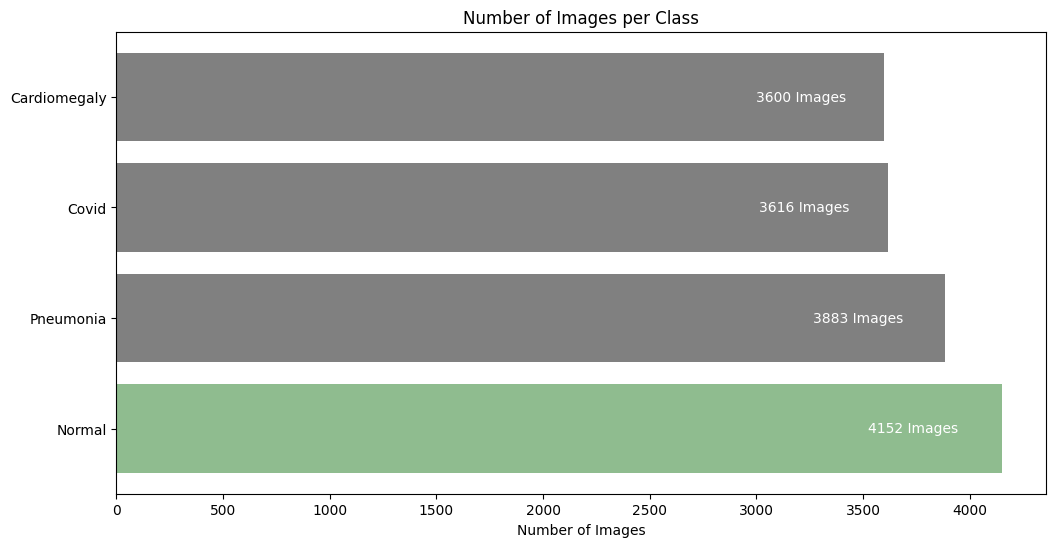

In [14]:
plot_image_distribution(image_counts, class_names, colors)

In [15]:
def plot_images(images, num_images=20):
    plt.figure(figsize=(15, 10))
    for i in range(num_images):
        ax = plt.subplot(4, 5, i + 1)
        plt.imshow(images[i])
        plt.title(f'Class: {classes[labels[i]]}')
        plt.axis("off")
    plt.tight_layout()
    plt.show()

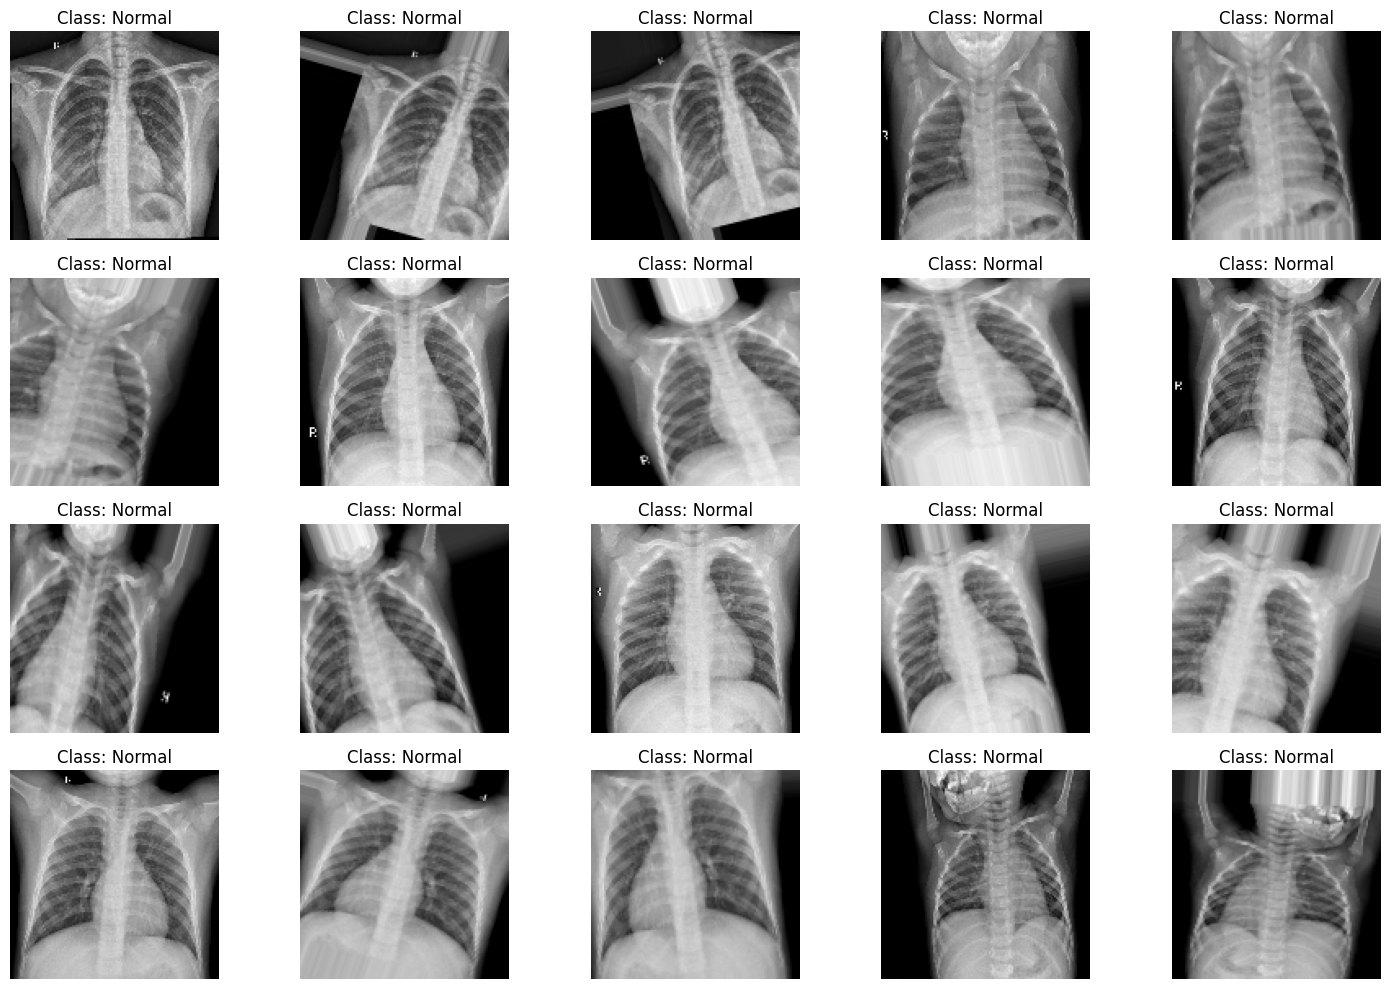

In [16]:
plot_images(normal_images)

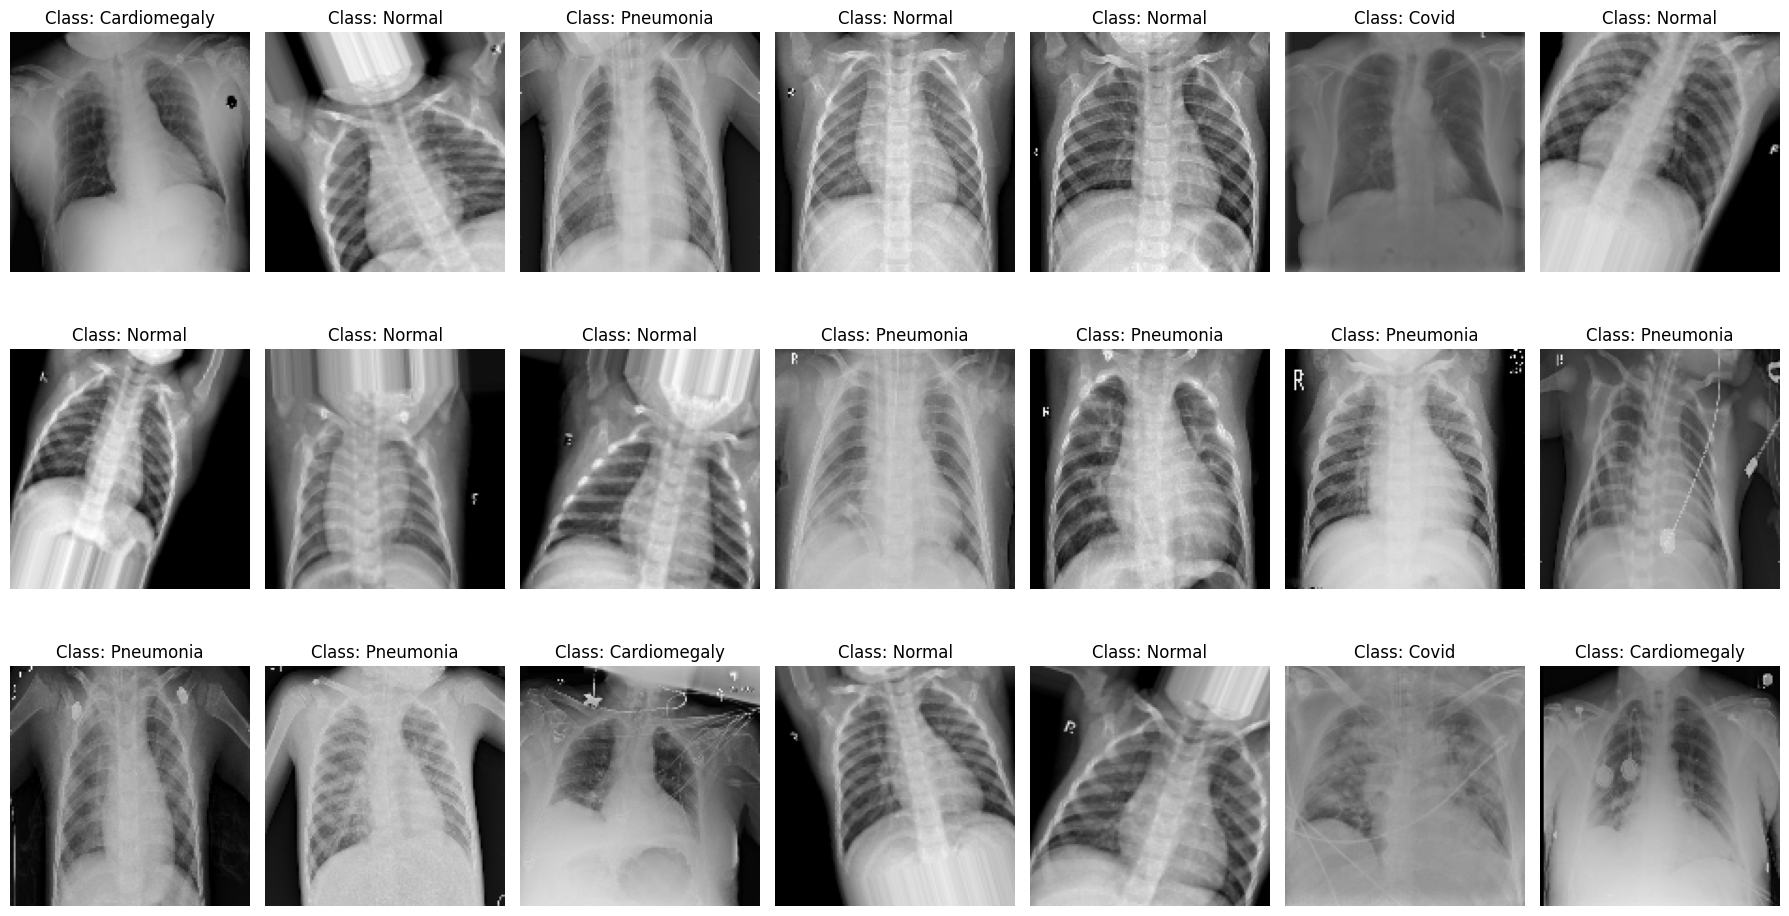

In [ ]:
plot_images(data)

In [14]:
print(len(data))

15251


In [15]:
data[0].shape

(128, 128, 3)

In [ ]:
X = np.array(data)
Y = np.array(labels)

In [17]:
print(X.shape)
print(Y.shape)

(15251, 128, 128, 3)
(15251,)


In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [ ]:
num_of_classes=4

model=keras.Sequential()

model.add(keras.layers.Conv2D(256, kernel_size=(3,3), input_shape=(128,128,3), kernel_regularizer=l2(0.01)))
model.add(keras.layers.LeakyReLU(alpha=0.01))
model.add(keras.layers.MaxPooling2D(pool_size=(2,2)))

model.add(keras.layers.Conv2D(128, kernel_size=(3,3), kernel_regularizer=l2(0.01)))
model.add(keras.layers.LeakyReLU(alpha=0.01))
model.add(keras.layers.MaxPooling2D(pool_size=(2,2)))

model.add(keras.layers.Conv2D(64, kernel_size=(3,3), kernel_regularizer=l2(0.01)))
model.add(keras.layers.LeakyReLU(alpha=0.01))
model.add(keras.layers.MaxPooling2D(pool_size=(2,2)))

model.add(keras.layers.Flatten())

model.add(keras.layers.Dense(128, activation='relu'))
model.add(keras.layers.Dropout(0.5))

model.add(keras.layers.Dense(num_of_classes, activation='softmax'))

model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (None, 126, 126, 256)     7168      
                                                                 
 max_pooling2d_15 (MaxPooli  (None, 63, 63, 256)       0         
 ng2D)                                                           
                                                                 
 conv2d_16 (Conv2D)          (None, 61, 61, 128)       295040    
                                                                 
 max_pooling2d_16 (MaxPooli  (None, 30, 30, 128)       0         
 ng2D)                                                           
                                                                 
 conv2d_17 (Conv2D)          (None, 28, 28, 64)        73792     
                                                                 
 max_pooling2d_17 (MaxPooli  (None, 14, 14, 64)       

In [52]:
optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=0.0005)

In [53]:
model.compile(
    optimizer=optimizer,
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [54]:
def exponential_decay(lr0, s):
    def decay(epoch):
        return lr0 * 0.99 ** (epoch / s)
    return decay


initial_lr = 0.0005
epochs_to_decay = 100

decay_fn = exponential_decay(initial_lr, epochs_to_decay)

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(decay_fn)

In [55]:
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("xray_model.h5",
                                                    save_best_only=True)

early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=15,
                                                     restore_best_weights=True)

In [56]:
history = model.fit(
    X_train,
    Y_train, 
    validation_split=0.1, 
    verbose=1, 
    epochs=50,
    callbacks=[
        checkpoint_cb, 
        early_stopping_cb, 
        lr_scheduler
    ]
)

Epoch 1/50


2024-11-23 21:17:01.627680: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


344/344 [==============================] - ETA: 0s - loss: 1.1241 - accuracy: 0.6139

2024-11-23 21:17:49.331669: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


344/344 [==============================] - 50s 144ms/step - loss: 1.1241 - accuracy: 0.6139 - val_loss: 0.6526 - val_accuracy: 0.7598 - lr: 5.0000e-04
Epoch 2/50


/opt/anaconda3/envs/LungDesiasePrediction/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


344/344 [==============================] - 50s 144ms/step - loss: 0.6694 - accuracy: 0.7780 - val_loss: 0.3883 - val_accuracy: 0.8582 - lr: 4.9995e-04
Epoch 3/50
344/344 [==============================] - 48s 140ms/step - loss: 0.4924 - accuracy: 0.8208 - val_loss: 0.3285 - val_accuracy: 0.8803 - lr: 4.9990e-04
Epoch 4/50
344/344 [==============================] - 48s 140ms/step - loss: 0.5189 - accuracy: 0.8277 - val_loss: 0.3358 - val_accuracy: 0.8803 - lr: 4.9985e-04
Epoch 5/50
344/344 [==============================] - 48s 139ms/step - loss: 0.4001 - accuracy: 0.8635 - val_loss: 0.3602 - val_accuracy: 0.9000 - lr: 4.9980e-04
Epoch 6/50
344/344 [==============================] - 48s 140ms/step - loss: 0.3601 - accuracy: 0.8811 - val_loss: 0.2925 - val_accuracy: 0.9139 - lr: 4.9975e-04
Epoch 7/50
344/344 [==============================] - 49s 142ms/step - loss: 0.3145 - accuracy: 0.8941 - val_loss: 0.2705 - val_accuracy: 0.9238 - lr: 4.9970e-04
Epoch 8/50
344/344 [===================

In [ ]:
loss, accuracy = model.evaluate(X_test, Y_test)

print("loss : ", loss)
print("accuracy : ", accuracy)

 1/96 [..............................] - ETA: 48s - loss: 0.5605 - accuracy: 0.8438

2024-11-25 19:37:32.591898: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


96/96 [==============================] - 4s 33ms/step - loss: 0.2896 - accuracy: 0.9017
loss :  0.2895561754703522
accuracy :  0.9016715884208679


<Axes: >

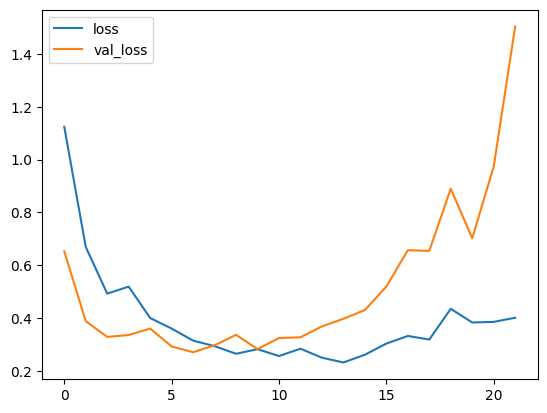

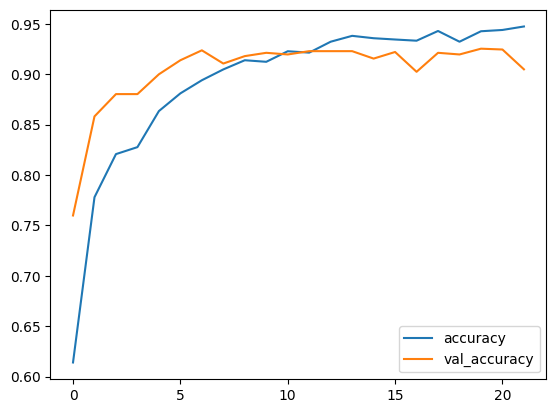

In [58]:
ef = pd.DataFrame(history.history)

ef[['loss','val_loss']].plot()
ef[['accuracy','val_accuracy']].plot()

In [37]:
xray_model = load_model('xray_model.h5')

2024-11-25 19:36:26.656260: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3 Pro
2024-11-25 19:36:26.657078: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 18.00 GB
2024-11-25 19:36:26.657088: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 6.00 GB
2024-11-25 19:36:26.657624: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-11-25 19:36:26.658017: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [45]:
y_pred = xray_model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)

print(classification_report(y_pred, Y_test))
print(confusion_matrix(y_pred, Y_test))

 5/96 [>.............................] - ETA: 3s

2024-11-25 20:01:06.134005: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


96/96 [==============================] - 2s 23ms/step
              precision    recall  f1-score   support

           0       0.91      0.96      0.93       806
           1       0.93      0.95      0.94       778
           2       0.88      0.86      0.87       773
           3       0.87      0.83      0.85       694

    accuracy                           0.90      3051
   macro avg       0.90      0.90      0.90      3051
weighted avg       0.90      0.90      0.90      3051

[[770  26   8   2]
 [ 32 739   5   2]
 [  8  19 663  83]
 [ 32   7  76 579]]


2/2 [==============================] - 1s 1s/step


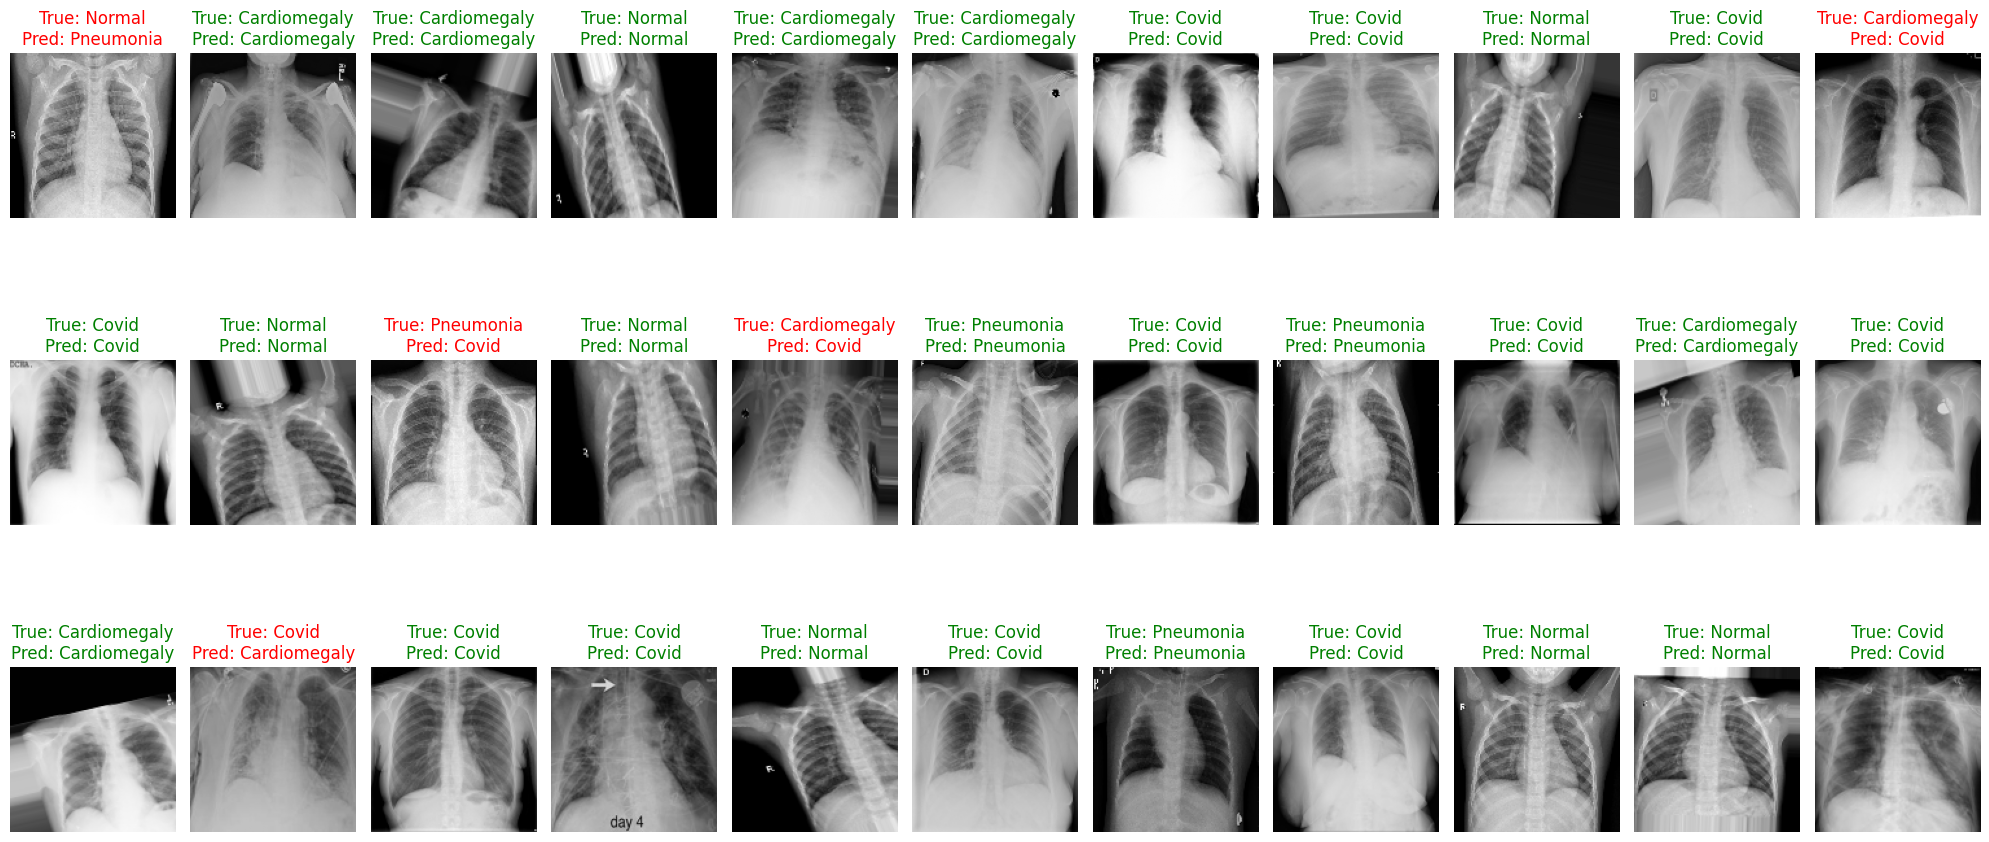

In [ ]:
num_images = 33

y_pred = xray_model.predict(X_test[:num_images])
y_pred_classes = np.argmax(y_pred, axis=1) 

plt.figure(figsize=(20, 10))

for i in range(num_images):

    plt.subplot(3, 11, i + 1)  
    plt.imshow(X_test[i].squeeze(), cmap='gray')

    true_label = classes[int(Y_test[i])]
    y_pred_p=classes[int(y_pred_classes[i])]

    color = 'green' if true_label == y_pred_p else 'red'

    plt.title(f"True: {true_label}\nPred: {y_pred_p}", color=color)
    plt.axis('off')

plt.tight_layout()
plt.show()